# 1. Abruf von Winddaten

1.0 Python Package importieren

In [8]:
import atlite
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, LineString, Point
from scipy.stats import weibull_min, rayleigh

1.1 Beschreibung der spezifischen Daten

In [9]:
island = {"Batanes","Bohol","Catanduanes","Marinduque","Tawi-Tawi"} # Insel von der Philipine
years = {"1980","1990","2000","2010","2020"} # Jahre der Winddaten
hub_height = {12,24,28.5,29,30} # Nabenhöhe

1.2 Cutout von Philipine offen

<AxesSubplot: >

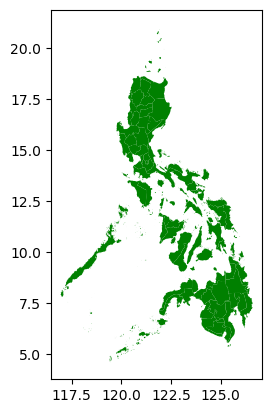

In [13]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg")
fig, ax = plt.subplots()
regions.plot(ax=ax,color='green')

1.3 Atlite aus verschiedenen Jahren herunterladen
- CDS API Schlüssel erforderlich https://cds.climate.copernicus.eu/api-how-to

In [ ]:
def download_wind_data(years):
    for year in years:
        minx, miny, maxx, maxy = regions.total_bounds
        buffer = 0.25

        cutout = atlite.Cutout(
           path=f"PHL_atlite_{year}.nc",
           module="era5",
           x=slice(minx-buffer, maxx+buffer),
           y=slice(miny-buffer, maxy+buffer),
           time=year,
        )
        print(f"Preparing Philipine Atlite for the year {year}")
        cutout.prepare()

In [ ]:
download_wind_data(years)

- das Atlite Ergebnis überprüfen

<GeoAxesSubplot: xlabel='x', ylabel='y'>

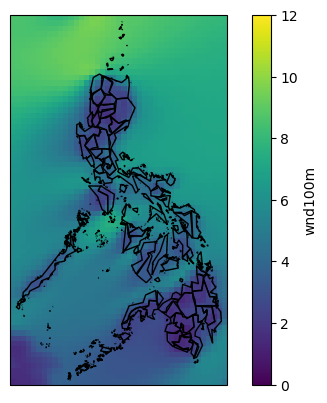

In [5]:
cutout = atlite.Cutout("PHL_atlite_2020.nc")

ax = plt.axes(projection=ccrs.PlateCarree())

cutout.data.wnd100m.mean(dim='time').plot(ax=ax, vmin=0, vmax=12) # Windgeschwindigkeit in 100 m
regions.simplify(0.1).to_crs(4236).plot(ax=ax, edgecolor='k', color='none')

<GeoAxesSubplot: xlabel='x', ylabel='y'>

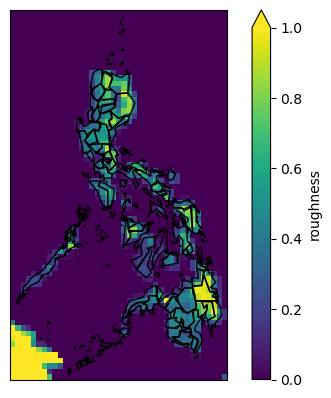

In [6]:
cutout = atlite.Cutout("PHL_atlite_2020.nc")

ax = plt.axes(projection=ccrs.PlateCarree())

cutout.data.roughness.mean(dim='time').plot(ax=ax, vmin=0, vmax=1) # Rauhigkeit der Oberfläche
regions.simplify(0.1).to_crs(4236).plot(ax=ax, edgecolor='k', color='none')

1.4 Zusammenstellung der Windhistogrammen für jede Insel, jedes Jahr und jede Nabenhöhe.

In [10]:
def extrapolate_wind_speed(hub_height,year):
    
    # Gleichung: v = v ref ln(z/z 0 )/ln(z ref /z 0 )
    cutout = atlite.Cutout(f"PHL_atlite_{year}.nc")
    wind_100 = cutout.data.wnd100m
    roughness = cutout.data.roughness
    wind_array = wind_100 * np.log(hub_height/roughness)/np.log(100/roughness)
    
    return wind_array

def region_wind(wind_array,region):
    cell_data=[]
    for x in np.arange(116.75,126.57,0.25):
        x = round(x,2)
        for y in np.arange(4.5,21.25,0.25):
            buffer = Point(x, y).buffer(0.25, cap_style = 3)
            if region.simplify(0.1).overlaps(buffer):
                x_cell = int((x - 116.8)*4)
                y_cell = int((y - 4.5)*4)
                cell_data= cell_data + [[y_cell,x_cell]]

    return sum(wind_array[:,y,x].to_pandas() for y,x in cell_data)/len(cell_data)
    
def compile_hist(island,hub_height,years):
    for height in hub_height:
        df = pd.DataFrame()
        for year in years:
            wind_array = extrapolate_wind_speed(height,year)
            for i in regions.index:
                if regions.NAME_1[i] in island:
                    print('compiling ' + regions.NAME_1[i]  + 'for year ' + year)
                    wind_series = region_wind(wind_array,regions.geometry[i])
                    n, bins = np.histogram(wind_series, bins=np.arange(0,35,1))
                    df_new = pd.DataFrame(n.reshape(-1, len(n)), index = [regions.NAME_1[i]])
                    
                    df_new["year"] = year
                    cols = df_new.columns.tolist()
                    cols = cols[-1:] + cols[:-1]
                    df_new = df_new[cols]
                    
                    df = pd.concat([df,df_new])

        df.to_csv(f'wind_histogram/wind_hist_{str(height)}_n.csv')
    return df

In [ ]:
df_hist = compile_hist(island,hub_height,years)

1.5 (Opts) Bestimmung der Weibul- und Rayleigh-Verteilung.

In [11]:
def wind_hist(df,name,wind_height):
    n, bins = np.histogram(df, bins=np.arange(0,35,1))
    wind=bins[:-1]#+0.5
    freq=n/8760
    
    plt.bar(x=wind,height=freq, width=1)
    x = np.arange(0,bins.max()*100.)/10.
    
    c, loc, scale = weibull_min.fit(df)
    plt.plot(x, weibull_min.pdf(x, c, loc, scale),'r-', lw=3, alpha=0.6, 
             label=f'weibull_min pdf \nk={round(c,2)} \nlambda={round(loc,2)}')
    
    loc, scale = rayleigh.fit(df)
    plt.plot(x, rayleigh.pdf(x, loc, scale),'g-', lw=3, alpha=0.6, 
             label=f'rayleigh pdf \nsigma={round(loc,2)}')
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Windgeschwindigkeit [m/s]')
    plt.ylabel('Häufigkeit')
    plt.xlim([0,34])
    plt.title(f'Wind Histogram of {name} in {wind_height}m')
    plt.legend()
    #plt.savefig(f'wind_histogram\wind_hist_100_{name}.png')

C:\Users\kunde\anaconda3\envs\esm\lib\site-packages\scipy\stats\_continuous_distns.py:7762: RuntimeWarning: divide by zero encountered in divide
  s3 = (1/xm).sum()


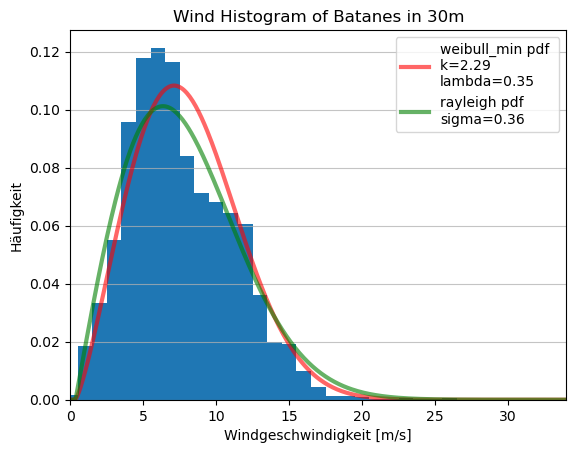

In [14]:
year=2000
region=10 # Batanes
wind_height=30 # 30 m

wind_array = extrapolate_wind_speed(wind_height,year)
wind_series = region_wind(wind_array,regions.geometry[region])
wind_hist(wind_series,regions.NAME_1[region],wind_height)

# 2. Abruf von Turbinendaten

2.0 Python Package importieren

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

import yaml
from yaml.loader import SafeLoader
from urllib.request import urlretrieve

2.1 Beschreibung der spezifischen Turbinendaten

In [9]:
turbine_typ = ['WES250','Vestas_V25_200kW','VesV20','En18','JI20kW']
columns = ['name','manufacturer','HUB_HEIGHT',
           0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
           20,21,22,23,24,25,26,27,28,29,30,31,32,33,34] 
turbine_df = pd.DataFrame(columns=columns,index=turbine_typ)

2.2 Zusammenstellung der Turbinendaten

In [10]:
for t in turbine_typ:
    with open(f'turbine/{t}.yaml','r') as f:
        data = yaml.load(f, Loader=SafeLoader)
        turbine_df.loc[t,'name']=data['name']
        turbine_df.loc[t,'manufacturer']=data['manufacturer']
        turbine_df.loc[t,'HUB_HEIGHT']=data['HUB_HEIGHT']
        
        for v in range(len(data['V'])):
            if turbine_df.loc[t,data['V'][v]]<data['POW'][v] or pd.isna(turbine_df.loc[t,data['V'][v]]):
                turbine_df.loc[t,data['V'][v]]=data['POW'][v]
                
        for v in range(33,-1,-1):
            if pd.isna(turbine_df.loc[t,v]) \
            and pd.isna(turbine_df.loc[t,v+1]) == False:
                turbine_df.loc[t,v]=turbine_df.loc[t,v+1]
                
turbine_df = turbine_df.fillna(0)
turbine_df.to_csv('turbine.csv')
turbine_df

,name,manufacturer,HUB_HEIGHT,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
WES250,WES250 250 kW,WES,30.0,0,0,0,0.001,0.0044,0.0149,0.0293,...,0.250,0,0,0,0,0,0,0,0,0
Vestas_V25_200kW,Vestas V25 200 kW,Vestas,29.0,0,0,0,0.000,0.0036,0.0123,0.0244,...,0.200,0,0,0,0,0,0,0,0,0
VesV20,Vestas V20 100 kW,Vestas,24.0,0,0,0,0.000,0.0000,0.0050,0.0130,...,0.105,0,0,0,0,0,0,0,0,0
En18,Enercon E18 80 kW,Enercon,28.5,0,0,0,0.000,0.0037,0.0081,0.0144,...,0.080,0,0,0,0,0,0,0,0,0
JI20kW,Jonica Impianti/ 20 kW,Jonica Impianti,12.0,0,0,0,0.000,0.0000,0.0005,0.0010,...,0.000,0,0,0,0,0,0,0,0,0


2.3 Leistungkurve erstellen

In [11]:
def leistung_hist(index):
    
    #df_parse = turbine_df.query(f"index == {index}")
    df = pd.DataFrame(columns=['POW'],index=list(range(0,35)))
    for i in range(0,35):
        df.loc[i,'POW']=turbine_df.loc[index,i]

    plt.bar(df.index,df['POW'], color='orange')
    plt.xlabel('Windgeschwindigkeit [m/s]')
    plt.ylabel('Leistung [MW]')
    plt.xlim([0, 30])
    plt.title(f'Leistungskurve von {index}')
    #plt.savefig(f'wind_histogram\leistungskurve_{index}.png')

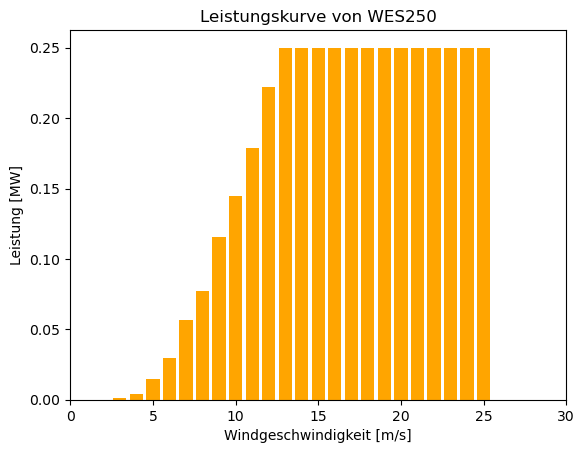

In [12]:
leistung_hist('WES250')

# 3. Berechnung des Energieertrags und Flautenanalyse

3.0 Python Package importieren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yaml
from yaml.loader import SafeLoader
from urllib.request import urlretrieve

3.1 Beschreibung der Tabellen für Energieerträge und Flautenanalyse

In [2]:
turbine_df = pd.read_csv('turbine.csv').rename(columns={'Unnamed: 0':'turbine'}).set_index('turbine')
turbine_typ = ['WES250','Vestas_V25_200kW','VesV20','En18','JI20kW']
island = ["Batanes","Bohol","Catanduanes","Marinduque","Tawi-Tawi"]
years = ["1980","1990","2000","2010","2020"]

3.2 Zusammenstellung des Energieertrags

In [3]:
power_df = pd.DataFrame(columns=island,index=pd.MultiIndex.from_product([years, turbine_typ]))

for (y,t) in power_df.index:
    turbine = turbine_df.loc[t]
    for r in power_df.columns:
        hub_height = round(float(turbine['HUB_HEIGHT']))
        while True:
            try:
                wind_df = pd.read_csv(f"wind_histogram/wind_hist_{hub_height}_n.csv").rename(columns={'Unnamed: 0':'region'}).set_index(['region','year'])
            except FileNotFoundError:
                hub_height = turbine['HUB_HEIGHT']
                continue
            break
        wind = wind_df.loc[r,int(y)]
        power_df.loc[(y,t),r] = sum(turbine.loc[str(n)]*wind.loc[str(n)] for n in range(len(wind)-1))

power_df.to_csv('results/energieertrag_MWh_a_all_year.csv')
power_df

Batanes     Bohol Catanduanes Marinduque Tawi-Tawi
1980 WES250             747.7724   59.8227    207.1001   108.3761   36.9759
     Vestas_V25_200kW   588.7119   45.8591    161.0502    83.2371   27.5839
     VesV20                304.6    17.811      80.902     39.536    10.214
     En18              281.59341  29.73991    87.68969   49.05332  18.90476
     JI20kW              35.1355      0.76      5.9295     2.2255     0.581
1990 WES250             742.5885   73.6565    197.3535   100.3089   54.1442
     Vestas_V25_200kW   585.0483   56.7446    152.8766    77.2994   40.8358
     VesV20               303.62     22.04      75.203     35.074    16.196
     En18              277.53715  36.05762    83.82789   44.85693  27.28937
     JI20kW              35.0615     1.214      5.8305     2.2575    0.9265
2000 WES250             748.3731   51.2078    205.4023   129.6568   42.8899
     Vestas_V25_200kW   588.9248   38.7176    159.3941    99.9715   31.7847
     VesV20               302.81     15.28      79.382     48.682     13.19
     En18              280.33491   24.5768    85.89398   56.04645   20.7348
     JI20kW              35.0915    0.7635       6.194      3.194    0.8295
2010 WES250             670.1601   37.2752      127.38    81.3699   28.6337
     Vestas_V25_200kW   527.3856   28.0587     97.9068    62.3352   20.8472
     VesV20              271.686     8.784      46.688      29.37     7.415
     En18              253.72972  19.52482    57.05883   36.82748  14.60094
     JI20kW               30.606    0.3295      3.0985      1.623    0.4175
2020 WES250             776.3222   44.3448    184.1952   125.8933   45.5401
     Vestas_V25_200kW   612.5076   33.5536    143.1263    96.8204   34.1574
     VesV20              315.604    11.667      70.776     47.307    13.572
     En18              287.99408  22.59203    77.63655   53.58156  22.83324
     JI20kW               36.746    0.4795      5.6175     3.2685     0.804

3.3 Energieertrags plotten

C:\Users\kunde\AppData\Local\Temp\ipykernel_21876\2741165710.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])
C:\Users\kunde\AppData\Local\Temp\ipykernel_21876\2741165710.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['','0 MWh','10 MWh','100 MWh','1000 MWh'])


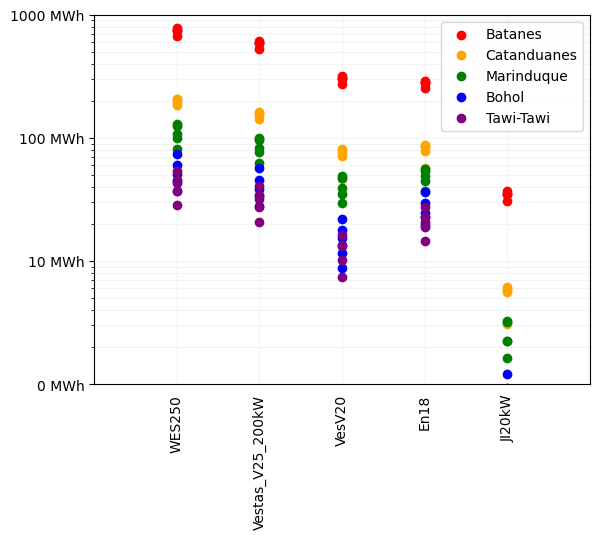

In [7]:
power_df = pd.read_csv("results/energieertrag_MWh_a_all_year.csv").rename(columns={'Unnamed: 0':'year','Unnamed: 1':'turbine'})

power_df["plot"] = 0
for i in power_df.index:
    if power_df.loc[i,"turbine"] == "WES250":
        power_df.loc[i,"plot"] = 1
    if power_df.loc[i,"turbine"] == "Vestas_V25_200kW":
        power_df.loc[i,"plot"] = 2
    if power_df.loc[i,"turbine"] == "VesV20":
        power_df.loc[i,"plot"] = 3
    if power_df.loc[i,"turbine"] == "En18":
        power_df.loc[i,"plot"] = 4
    if power_df.loc[i,"turbine"] == "JI20kW":
        power_df.loc[i,"plot"] = 5
        
# The target ist to create an array where the color is based on the region while the x axis is based on turbine
fig, ax = plt.subplots()

plt.scatter(power_df["plot"], power_df['Batanes'], c='red', label='Batanes')
plt.scatter(power_df["plot"], power_df['Catanduanes'], c='orange', label='Catanduanes')
plt.scatter(power_df["plot"], power_df['Marinduque'], c='green', label='Marinduque')
plt.scatter(power_df["plot"], power_df['Bohol'], c='blue', label='Bohol')
plt.scatter(power_df["plot"], power_df['Tawi-Tawi'], c='purple', label='Tawi-Tawi')

plt.yscale('log')
ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])
ax.set(yticklabels=['','0 MWh','10 MWh','100 MWh','1000 MWh'])

plt.xticks(rotation=90)
ax.tick_params(bottom=False)
plt.ylim([1, 1000])
plt.xlim([0, 6])

plt.grid(axis='x',color='0.95', which='major')
plt.grid(axis='y',color='0.95', which='both')
ax.set_axisbelow(True)

plt.legend()
plt.savefig('leistung.png')

3.4 Zusammenstellung der Flautenanalyse

In [4]:
nopower_df = pd.DataFrame(columns=island,index=pd.MultiIndex.from_product([years, turbine_typ]))

for (y,t) in nopower_df.index:
    turbine = turbine_df.loc[t]
    neg_turbine = turbine.copy(deep=True)
    
    for i in neg_turbine.index:
        if neg_turbine.loc[i] == 0:
            neg_turbine.loc[i] = 1
        elif isinstance(neg_turbine.loc[i], float):
            neg_turbine.loc[i] = 0
    
    for r in nopower_df.columns:
        hub_height = round(float(turbine['HUB_HEIGHT']))
        while True:
            try:
                wind_df = pd.read_csv(f"wind_histogram/wind_hist_{hub_height}_n.csv").rename(columns={'Unnamed: 0':'region'}).set_index(['region','year'])
            except FileNotFoundError:
                hub_height = turbine['HUB_HEIGHT']
                continue
            break
        wind = wind_df.loc[r,int(y)]
        nopower_df.loc[(y,t),r] = sum(neg_turbine.loc[str(n)]*wind.loc[str(n)] for n in range(len(wind)))

nopower_df.to_csv('results/flautenanalyse_h_a.csv')
nopower_df

Batanes Bohol Catanduanes Marinduque Tawi-Tawi
1980 WES250               375  3783        2016       3456      3900
     Vestas_V25_200kW     867  5340        3675       4987      6182
     VesV20              1570  6997        5439       6423      7755
     En18                 870  5353        3692       4993      6192
     JI20kW              1840  7714        5993       6884      8018
1990 WES250               612  3168        2106       3481      2807
     Vestas_V25_200kW    1274  4537        3613       5146      5314
     VesV20              2076  6792        5303       6659      7164
     En18                1276  4556        3627       5166      5327
     JI20kW              2370  7657        5868       7207      7565
2000 WES250               470  4150        2422       3443      3814
     Vestas_V25_200kW     956  5974        3964       5088      6313
     VesV20              1867  7632        5552       6569      7753
     En18                 959  5997        3973       5101      6328
     JI20kW              2223  8124        6036       7037      7958
2010 WES250               666  4310        2294       4238      4181
     Vestas_V25_200kW    1291  5862        4306       5816      6625
     VesV20              2238  7751        6244       6930      7955
     En18                1300  5877        4318       5835      6632
     JI20kW              2576  8311        6698       7401      8201
2020 WES250               591  4213        2185       3977      3741
     Vestas_V25_200kW    1265  5812        4051       5418      5914
     VesV20              2112  7484        5868       6678      7529
     En18                1266  5820        4066       5434      5920
     JI20kW              2460  8022        6421       7069      7777

3.5 Flautenanalyse plotten

C:\Users\kunde\AppData\Local\Temp\ipykernel_21876\3429836892.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])


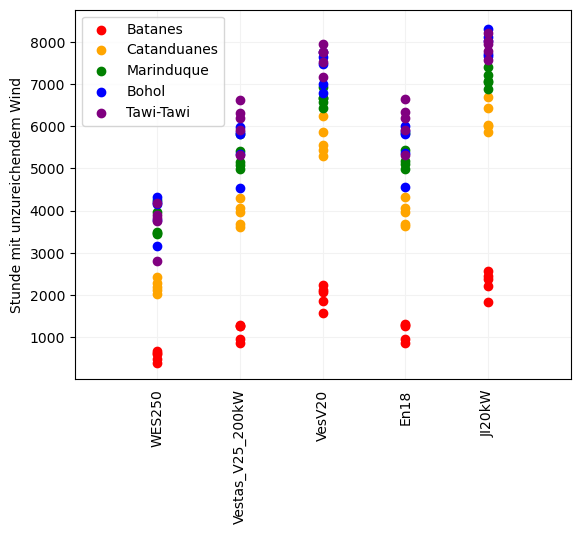

In [6]:
nopower_df = pd.read_csv("results/flautenanalyse_h_a.csv").rename(columns={'Unnamed: 0':'year','Unnamed: 1':'turbine'})

nopower_df["plot"] = 0
for i in nopower_df.index:
    if nopower_df.loc[i,"turbine"] == "WES250":
        nopower_df.loc[i,"plot"] = 1
    if nopower_df.loc[i,"turbine"] == "Vestas_V25_200kW":
        nopower_df.loc[i,"plot"] = 2
    if nopower_df.loc[i,"turbine"] == "VesV20":
        nopower_df.loc[i,"plot"] = 3
    if nopower_df.loc[i,"turbine"] == "En18":
        nopower_df.loc[i,"plot"] = 4
    if nopower_df.loc[i,"turbine"] == "JI20kW":
        nopower_df.loc[i,"plot"] = 5
        
# The target ist to create an array where the color is based on the region while the x axis is based on turbine
fig, ax = plt.subplots()#figsize=(7,6)

plt.scatter(nopower_df["plot"], nopower_df['Batanes'], c='red', label='Batanes')
plt.scatter(nopower_df["plot"], nopower_df['Catanduanes'], c='orange', label='Catanduanes')
plt.scatter(nopower_df["plot"], nopower_df['Marinduque'], c='green', label='Marinduque')
plt.scatter(nopower_df["plot"], nopower_df['Bohol'], c='blue', label='Bohol')
plt.scatter(nopower_df["plot"], nopower_df['Tawi-Tawi'], c='purple', label='Tawi-Tawi')

#plt.yscale('log')
ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])
#ax.set(yticklabels=['','0 MWh','10 MWh','100 MWh','1000 MWh'])

plt.xticks(rotation=90)
ax.tick_params(bottom=False)
plt.ylim([1, 8760])
plt.xlim([0, 6])

plt.grid(axis='x',color='0.95', which='major')
plt.grid(axis='y',color='0.95', which='both')
ax.set_axisbelow(True)

plt.legend()
plt.ylabel('Stunde mit unzureichendem Wind')

plt.savefig('flauten.png')